In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedKFold, cross_val_score
import optuna
from sklearn.metrics import mean_squared_error
import shap
import joblib

In [2]:
# Load datasets
train_df = pd.read_csv("/kaggle/input/parkinson/train.csv")
test_df = pd.read_csv("/kaggle/input/parkinson/test.csv")
val_df = pd.read_csv("/kaggle/input/parkinson/val.csv")

# Define features and target
target_col = "motor_UPDRS" 
target_and_related = ["motor_UPDRS", "subject#", "total_UPDRS"]

# Split datasets
X_train = train_df.drop(columns=target_and_related)
y_train = train_df[target_col]

X_test = test_df.drop(columns=target_and_related)
y_test = test_df[target_col]

X_val = val_df.drop(columns=target_and_related)
y_val = val_df[target_col]

In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

# Initialize CatBoostRegressor
model = CatBoostRegressor(verbose=0, random_state=42)

# Perform K-Fold Cross-Validation (for regression)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
    X_fold_train, y_fold_train = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_fold_val, y_fold_val = X_train.iloc[val_idx], y_train.iloc[val_idx]
    
    # Train the model
    model.fit(X_fold_train, y_fold_train)
    
    # Predict on the validation set
    y_fold_pred = model.predict(X_fold_val)
    
    # Calculate RMSE for the fold
    fold_rmse = np.sqrt(mean_squared_error(y_fold_val, y_fold_pred))
    rmse_scores.append(fold_rmse)
    
    # Print RMSE for the current fold
    print(f"Fold {fold_idx}: RMSE = {fold_rmse:.4f}")

# Print all fold RMSE scores
print(f"\nAll fold RMSE scores: {rmse_scores}")

# Calculate and print mean and standard deviation of RMSE scores
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)
print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Std RMSE: {std_rmse:.4f}")

Fold 1: RMSE = 1.8823
Fold 2: RMSE = 1.8523
Fold 3: RMSE = 1.9111
Fold 4: RMSE = 1.6759
Fold 5: RMSE = 1.7615

All fold RMSE scores: [1.8823316799769019, 1.8522785260517143, 1.9110672732589835, 1.675917150282943, 1.761498234227699]
Mean RMSE: 1.8166
Std RMSE: 0.0864


In [4]:
# Define objective function for Optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 100, 1000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "verbose": 0,
        "random_state": 42,
    }
    
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train)
    val_preds = model.predict(X_val)
    return mean_squared_error(y_val, val_preds)

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-02-22 13:57:26,606] A new study created in memory with name: no-name-a1b4ea9f-6d58-4418-962f-52d9b147b98c
[I 2025-02-22 13:57:27,946] Trial 0 finished with value: 2.3930359328564452 and parameters: {'iterations': 393, 'learning_rate': 0.0997745055560071, 'depth': 6, 'l2_leaf_reg': 0.03478336042675188, 'random_strength': 0.005318172398419263, 'bagging_temperature': 0.4415302127244578}. Best is trial 0 with value: 2.3930359328564452.
[I 2025-02-22 13:57:29,376] Trial 1 finished with value: 3.6040632288157655 and parameters: {'iterations': 840, 'learning_rate': 0.2801286814974496, 'depth': 4, 'l2_leaf_reg': 0.033226273577875796, 'random_strength': 0.30064554337752847, 'bagging_temperature': 0.8663867400356329}. Best is trial 0 with value: 2.3930359328564452.
[I 2025-02-22 13:57:30,177] Trial 2 finished with value: 7.455490173880023 and parameters: {'iterations': 464, 'learning_rate': 0.0480300718335579, 'depth': 4, 'l2_leaf_reg': 0.019290123606209627, 'random_strength': 0.00194330

Best hyperparameters: {'iterations': 974, 'learning_rate': 0.07351288341507646, 'depth': 8, 'l2_leaf_reg': 0.007933209429738401, 'random_strength': 0.0780786311766236, 'bagging_temperature': 0.2742901808536797}


In [5]:
# Train the model with best hyperparameters
best_params = study.best_params
best_model = CatBoostRegressor(**best_params, verbose=0, random_state=42)
best_model.fit(X_train, y_train)

# Save the model
joblib.dump(best_model, "/kaggle/working/best_catboost_model.pkl")

['/kaggle/working/best_catboost_model.pkl']

age: 56.88618407050887
sex: 15.808267201020984
test_time: 5.279738586502214
Jitter(%): 0.256062278070335
Jitter(Abs): 2.3310399409825218
Jitter:RAP: 0.29890600402495554
Jitter:PPQ5: 0.20613348160005776
Jitter:DDP: 0.4161203083500814
Shimmer: 0.1209630851235284
Shimmer(dB): 0.4400957987904319
Shimmer:APQ3: 0.9090050098155668
Shimmer:APQ5: 1.3626121203641424
Shimmer:APQ11: 0.2728706049633145
Shimmer:DDA: 0.3548368647255566
NHR: 0.311126481060214
HNR: 0.9777577698547182
RPDE: 2.50401399531515
DFA: 10.856274665168295
PPE: 0.40799173375908027


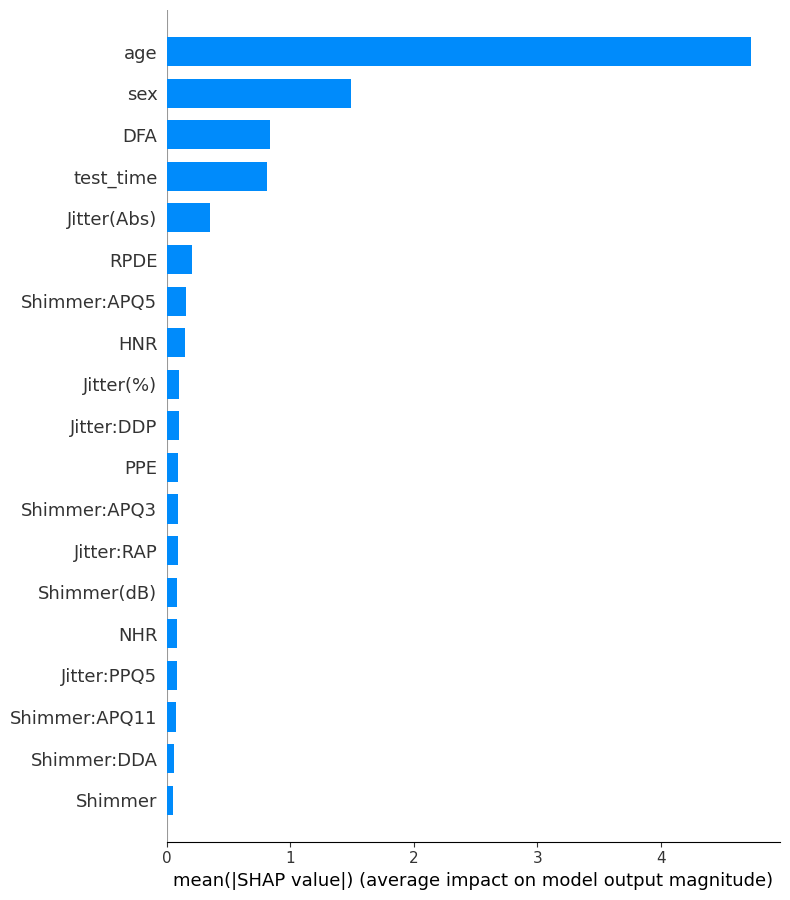

In [6]:
# Feature Importance
feature_importances = best_model.get_feature_importance()
feature_names = X_train.columns
for feature_name, importance in zip(feature_names, feature_importances):
    print(f"{feature_name}: {importance}")

# SHAP Analysis
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [7]:
import joblib
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load the saved model
loaded_model = joblib.load("best_catboost_model.pkl")

# Make predictions on test data
test_preds = loaded_model.predict(X_test)

# Evaluate the model
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)  # RMSE
test_mae = mean_absolute_error(y_test, test_preds)  # MAE
test_r2 = r2_score(y_test, test_preds)  # R² Score

# Print results
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")


Test RMSE: 1.3650
Test MAE: 0.9068
Test R² Score: 0.9719
